<a href="https://colab.research.google.com/github/9M3a1h3d9i9/RL_Bots/blob/main/TD(DQNA1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In the name Of GOD

#In The Name Of GOD

#DS Presentation : by Mohammad Mahdi Shafighy

#Winter 1403

#1-Add a Graphic report
#2-Increase the number of enemies     <--
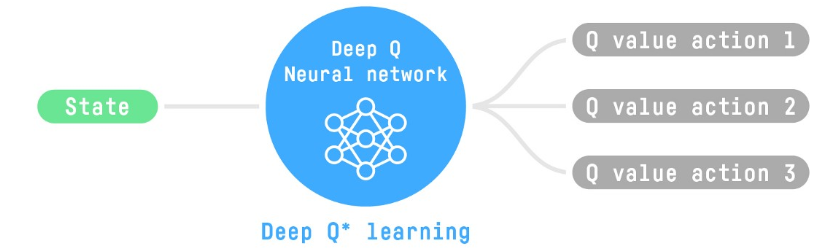

#####The code simulates a tower defense game environment and uses deep Q-Reinforcement learning to train the intelligent agent to learn how to create the best defense strategy.


In [11]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time

# Important changes:
##Show agent movement:
 The render function has been updated to show the state of the network.
##Time Limit:
 Set the duration of each episode to 10 seconds.
##Score Chart:
The total score of each episode is displayed at the end.

 # Definition of the game environment (TowerDefenseEnv)

The TowerDefenseEnv class defines the game environment :

#Game grid:
A two-dimensional grid measuring 10x10 that includes paths, towers, enemies, and bullets.

Number 0: Empty cell.

Number 1: Enemy path.

Number 2: Tower.

Number 3: Enemy.

Number 8: Bullet.

Number -1: Enemy eliminated.

#Path of enemy movement:
The path along which the enemies move.

#Towers:
 The player can place towers on the grid.

#Resources:
امتیاز قراردادن برج در بصورت تصادفی

 The number of initial resources for the player (for placing towers).

#Main environmental functions:

##reset:
 It resets the environment and starts a new game.
##step:
 Executes a step of the game. This function:
The agent action (adding a tower) is processed.
It manages the enemy's movement along the path.

It fires bullets from the towers and checks the impact of the bullets on the enemies.

Calculates the reward.

#render:
prints the current state of the network.

In [12]:
class TowerDefenseEnv:
    def __init__(self, grid_size=(10, 10), max_steps=50):
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.enemies = []
        self.reset()

    def reset(self):
        self.grid = np.zeros(self.grid_size, dtype=int)
        self.grid[2, 0:5] = 1
        self.grid[2:7, 4] = 1
        self.grid[6, 4:9] = 1
        self.enemies = [[2, 0], [2, 1], [2, 2]]
        self.towers = []
        self.bullets = []
        self.resources = 10
        self.step_count = 0
        self.total_reward = 0
        return self.grid.copy()

    def step(self, action):
        reward = 0
        done = False

        # Build Tower
        if action < self.grid_size[0] * self.grid_size[1]:
            x, y = divmod(action, self.grid_size[1])
            if self.grid[x, y] == 0 and self.resources >= 5:
                self.grid[x, y] = 2
                self.towers.append((x, y))
                self.resources -= 5

        # Enemeis Movemet
        for enemy in self.enemies:
            if self.grid[tuple(enemy)] == 3:
                self.grid[tuple(enemy)] = 1
            if enemy[1] < 4:
                enemy[1] += 1
            elif enemy[0] < 6:
                enemy[0] += 1
            elif enemy[1] < 8:
                enemy[1] += 1
            else:
                done = True
                reward -= 10

            self.grid[tuple(enemy)] = 3

        # Towers Shooting
        for tower in self.towers:
            tower_x, tower_y = tower
            for enemy in self.enemies:
                if abs(tower_x - enemy[0]) + abs(tower_y - enemy[1]) <= 2:
                    bullet = (tower_x, tower_y, enemy, 10)
                    self.bullets.append(bullet)

        # Tower Attack Logic
        new_bullets = []
        destroyed_enemies = []
        for bullet in self.bullets:
            bullet_x, bullet_y, target, damage = bullet
            if bullet_x < target[0]:
                bullet_x += 1
            elif bullet_x > target[0]:
                bullet_x -= 1
            if bullet_y < target[1]:
                bullet_y += 1
            elif bullet_y > target[1]:
                bullet_y -= 1

            if [bullet_x, bullet_y] == target:
                reward += damage
                destroyed_enemies.append(target)
            else:
                new_bullets.append((bullet_x, bullet_y, target, damage))

        self.bullets = new_bullets
        self.enemies = [enemy for enemy in self.enemies if enemy not in destroyed_enemies]

        self.step_count += 1
        self.total_reward += reward
        if self.step_count >= self.max_steps or not self.enemies:
            done = True

        return self.grid.copy(), reward, done

    def render(self):
        for row in self.grid:
            print(" ".join(['.' if cell == 0 else 'P' if cell == 1 else 'T' if cell == 2 else 'E' if cell == 3 else 'B' for cell in row]))
        print("\n")

#Definition of the agent (DQNAgent)
The DQNAgent class defines an intelligent agent that uses the Deep Q-Network (DQN) algorithm.

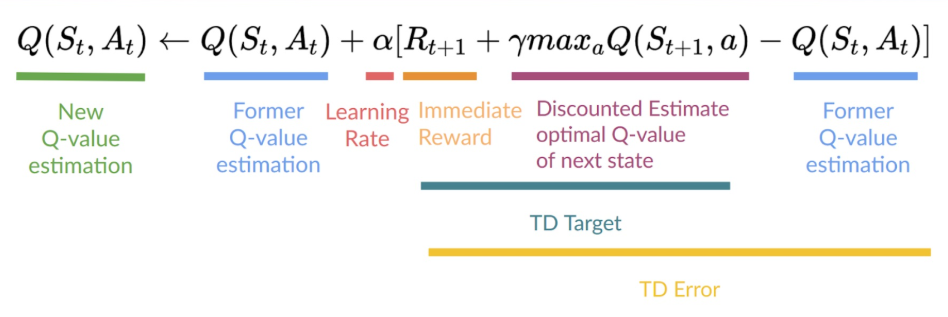
##Main components of the agent:

###Neural network model:
####Input:
 Environment state *(flattened)*.
####Output:
 The Q value for each possible action.
####Architecture:
 It includes Dense layers with *ReLU activation*.

##Action selection strategy:
###Exploration:
 Chooses a random action with **probability ε**.
###Exploitation:
 It selects the action that has the **highest Q value**.
#Learning:
####It uses the **Experience Replay method** for learning.

####It updates the estimated **future reward using the Q value**.

In [13]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Flatten(input_shape=(self.state_size,)),
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

#Training the agent (train_tower_defense)
This function trains the agent in the environment:


###The game is played in several episodes (here, 500 episodes).
####In each episode, the agent **observes the state of the environment** and **takes action based on its model**.

#####After each episode, the **total reward** is *stored*, and the `agent replays experiences` `from memory` **to improve its model**.
The agent's performance during the episodes is plotted on a graph.

##### Add --->>`Game Time`<<--- to game    

In [14]:
def train_tower_defense():
    env = TowerDefenseEnv()
    state_size = env.grid_size[0] * env.grid_size[1]
    action_size = state_size
    agent = DQNAgent(state_size, action_size)
    episodes = 100
    batch_size = 32

    scores = []
    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        total_reward = 0
        start_time = time.time()
        while time.time() - start_time < 10:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break

        scores.append(total_reward)
        agent.replay(batch_size)

    plt.figure(figsize=(24, 9))
    plt.plot(range(len(scores)), scores, marker='.', linestyle='-', color='b')
    plt.title('Tower Defense Game: Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid()
    plt.show()

# Train DQN Model

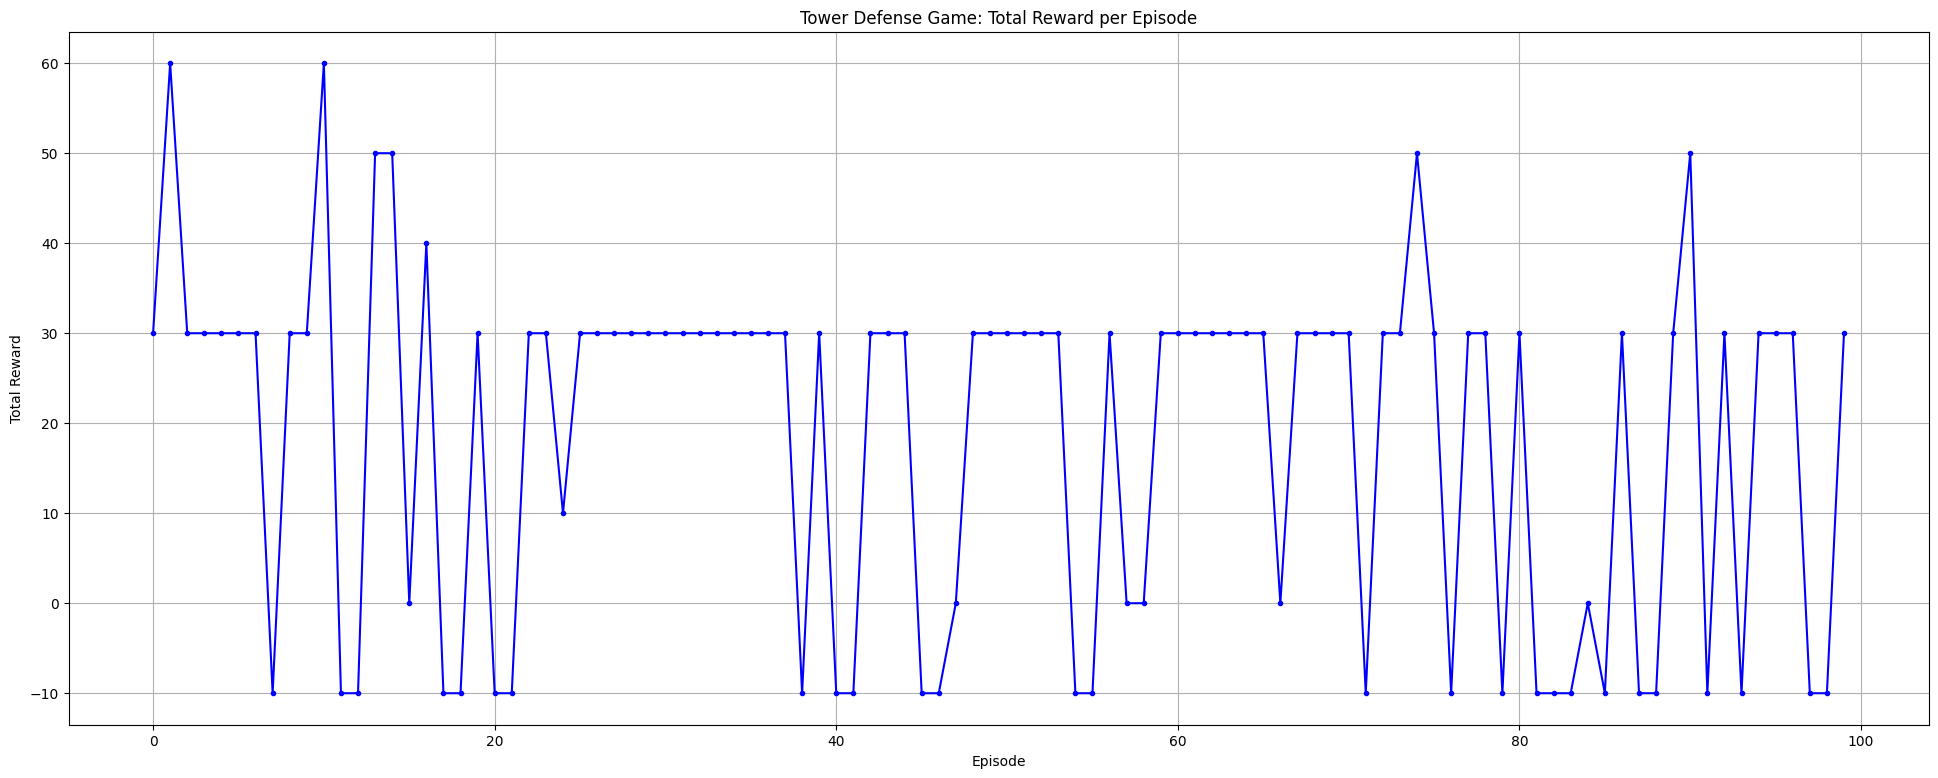

In [15]:
train_tower_defense()
